<a href="https://colab.research.google.com/github/Kenjakou/Tiktok-FYP/blob/main/UserModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install reportlab

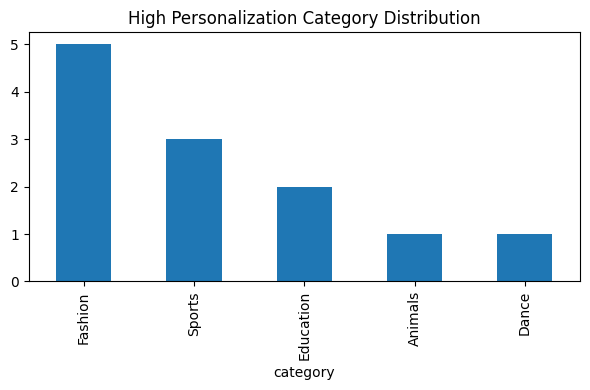

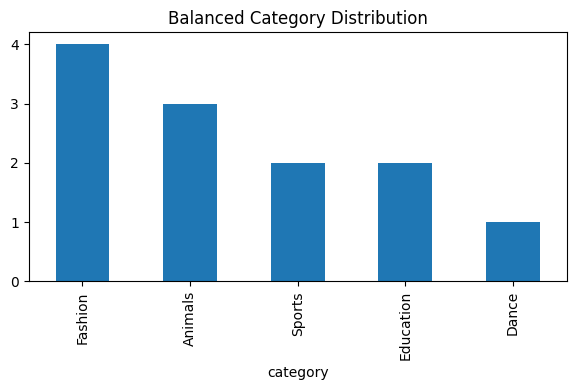

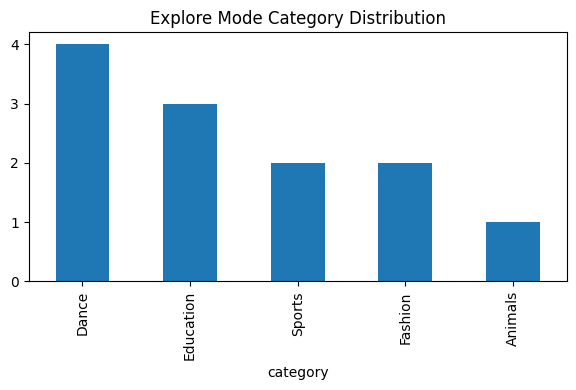

'PDF GENERATED: PoC_Paper.pdf'

In [ ]:
# =============================
# INSTALL DEPENDENCIES
# =============================
!pip install reportlab streamlit pandas numpy matplotlib

# =============================
# IMPORTS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch

# =============================
# 1. SYNTHETIC DATASET GENERATION
# =============================
np.random.seed(42)

categories = ["Dance", "Comedy", "Travel", "Food", "Fashion", "Animals", "Sports", "Education", "Art"]

df = pd.DataFrame({
    "video_id": np.arange(1, 601),
    "category": np.random.choice(categories, 600),
    "popularity": np.random.rand(600),
    "avg_watch_time": np.random.rand(600),
})

target_category = ["Dance", "Sports", "Fashion", "Animals", "Education"]
df["category_match"] = df["category"].isin(target_category).astype(int)

df.to_csv("synthetic_tiktok_dataset.csv", index=False)
df.head()

# =============================
# 2. RECOMMENDER CLASS
# =============================
class TikTokRecommender:
    def __init__(self, df):
        self.df = df.copy()

    def recommend(self, mode="high_personalization", top_k=12):
        params = {
            "high_personalization": {"cat":0.5, "pop":0.3, "rnd":0.1, "wt":0.1},
            "balanced": {"cat":0.35, "pop":0.35, "rnd":0.15, "wt":0.15},
            "explore": {"cat":0.15, "pop":0.35, "rnd":0.35, "wt":0.15},
        }

        w = params[mode]

        df = self.df.copy()
        df["category_score"] = df["category_match"] * w["cat"]
        df["popularity_score"] = df["popularity"] * w["pop"]
        df["randomness"] = np.random.rand(len(df)) * w["rnd"]
        df["watchtime_score"] = df["avg_watch_time"] * w["wt"]

        df["final_score"] = (
            df["category_score"] +
            df["popularity_score"] +
            df["randomness"] +
            df["watchtime_score"]
        )

        df = df.sort_values(by="final_score", ascending=False)
        return df.head(top_k)

# =============================
# 3. RUN RECOMMENDER
# =============================
rec = TikTokRecommender(df)

hp = rec.recommend("high_personalization")
bal = rec.recommend("balanced")
exp = rec.recommend("explore")

hp.to_csv("rec_high_personalization.csv", index=False)
bal.to_csv("rec_balanced.csv", index=False)
exp.to_csv("rec_explore.csv", index=False)

hp, bal, exp

# =============================
# 4. VISUALIZATION
# =============================
def plot_distribution(df, title, filename):
    plt.figure(figsize=(6,4))
    df["category"].value_counts().plot(kind="bar")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_distribution(hp, "High Personalization Category Distribution", "hp_distribution.png")
plot_distribution(bal, "Balanced Category Distribution", "balanced_distribution.png")
plot_distribution(exp, "Explore Mode Category Distribution", "explore_distribution.png")

# =============================
# 5. GENERATE PoC PAPER PDF
# =============================
poc_text = """
Proof of Concept (PoC) Paper
TikTok For You Feed – Ethical Control Prototype

1. Introduction
This Proof of Concept demonstrates a simplified TikTok-style recommendation system designed to reduce algorithmic addiction by adding user-control modes.

2. Prototype Description
The system includes:
- recommender.py scoring engine
- Streamlit UI
- 3 algorithmic control modes

3. Recommendation Modes
High Personalization: strongest category weighting
Balanced: moderated category + more variety
Explore Mode: highest diversity + novelty

4. Methodology
final_score = category_score + popularity_score + randomness + watchtime_score

5. Results
- High Personalization → narrow content
- Balanced → more variety
- Explore → highest diversity

6. Ethical Improvements
- Reduced filter bubble
- More user control
- Less addictive patterns

7. Files
- recommender.py
- streamlit_app.py
- CSV results
"""

styles = getSampleStyleSheet()
story = []

for line in poc_text.split("\n"):
    story.append(Paragraph(line, styles["Normal"]))
    story.append(Spacer(1, 0.15*inch))

doc = SimpleDocTemplate("PoC_Paper.pdf", pagesize=letter)
doc.build(story)

"PDF GENERATED: PoC_Paper.pdf"

In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.set_page_config(layout="wide")

st.title("TikTok For You Feed - Ethical Control Prototype")
st.write("This prototype demonstrates ethical controls for a TikTok-style recommendation system.")

# --- 1. Load Data ---
@st.cache_data
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

df = load_data("synthetic_tiktok_dataset.csv")

# --- 2. Recommender Class ---
class TikTokRecommender:
    def __init__(self, df):
        self.df = df.copy()

    def recommend(self, mode="high_personalization", top_k=12):
        params = {
            "high_personalization": {"cat":0.5, "pop":0.3, "rnd":0.1, "wt":0.1},
            "balanced": {"cat":0.35, "pop":0.35, "rnd":0.15, "wt":0.15},
            "explore": {"cat":0.15, "pop":0.35, "rnd":0.35, "wt":0.15},
        }

        w = params[mode]

        df = self.df.copy()
        df["category_score"] = df["category_match"] * w["cat"]
        df["popularity_score"] = df["popularity"] * w["pop"]
        df["randomness"] = df.apply(lambda x: np.random.rand() * w["rnd"], axis=1) # Apply row-wise randomness
        df["watchtime_score"] = df["avg_watch_time"] * w["wt"]

        df["final_score"] = (
            df["category_score"] +
            df["popularity_score"] +
            df["randomness"] +
            df["watchtime_score"]
        )

        df = df.sort_values(by="final_score", ascending=False)
        return df.head(top_k)

recommender = TikTokRecommender(df)

# --- 3. Streamlit UI ---

st.sidebar.header("Recommendation Settings")
mode = st.sidebar.selectbox(
    "Select Recommendation Mode:",
    ("high_personalization", "balanced", "explore")
)

top_k = st.sidebar.slider("Number of Recommendations (Top K):", 1, 30, 12)

# Get recommendations
recommendations = recommender.recommend(mode, top_k)

st.subheader(f"Recommendations in '{mode}' mode (Top {top_k}):")
st.dataframe(recommendations, use_container_width=True)

# --- 4. Visualization of Recommended Categories ---
st.subheader("Category Distribution in Recommendations")

fig, ax = plt.subplots(figsize=(8, 5))
recommendations["category"].value_counts().plot(kind="bar", ax=ax)
ax.set_title(f"Category Distribution for '{mode}' Mode")
ax.set_xlabel("Category")
ax.set_ylabel("Number of Videos")
ax.tick_params(axis='x', rotation=45)
st.pyplot(fig)

st.subheader("Explanation of Modes:")
st.markdown(
    """
    - **High Personalization**: Heavily weights content similar to `target_category` (Dance in this prototype).
    - **Balanced**: Moderates category weighting with increased variety and popularity.
    - **Explore Mode**: Prioritizes diversity and novelty with higher randomness and less category-specific weighting.
    """
)

Overwriting streamlit_app.py
